In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
#from torchsummary import summary
import math
import pandas as pd
import torch.nn.functional as F
import random
import torch.optim as optim
from scipy.io import loadmat
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import scipy.io

# Import data

The data used in this was saved as mat files. the syntax used to extract the data is just because the data is mat file format and not csv

In [2]:
file_path = r"C:\Users\steph\OneDrive\Desktop\Stephen\ADCL\thesis stuff\Thomas_Schill_Sim\parametersdata.mat"
params_all =  scipy.io.loadmat(file_path)
params = params_all['parameters_data_1']
params.shape

(750, 4)

In [3]:
file_path = r"C:\Users\steph\OneDrive\Desktop\Stephen\ADCL\thesis stuff\Thomas_Schill_Sim\pilotoutput.mat"
p_all = scipy.io.loadmat(file_path)
p = p_all['pilot_output_data']

file_path = r"C:\Users\steph\OneDrive\Desktop\Stephen\ADCL\thesis stuff\Thomas_Schill_Sim\pitcherror.mat"
theta_error_all = scipy.io.loadmat(file_path)
theta_error = theta_error_all['pitch_error_data']

file_path = r"C:\Users\steph\OneDrive\Desktop\Stephen\ADCL\thesis stuff\Thomas_Schill_Sim\pitchoutput.mat"
theta_out_all = scipy.io.loadmat(file_path)
theta_out = theta_out_all['pitch_output_data']

file_path = r"C:\Users\steph\OneDrive\Desktop\Stephen\ADCL\thesis stuff\Thomas_Schill_Sim\pitchcmd.mat"
theta_cmd_all = scipy.io.loadmat(file_path)
theta_cmd = theta_cmd_all['pitch_commanded_data']

file_path = r"C:\Users\steph\OneDrive\Desktop\Stephen\ADCL\thesis stuff\Thomas_Schill_Sim\xp.mat"
xp_all = scipy.io.loadmat(file_path)


In [4]:
xp = xp_all['xpilot_data']

In [ ]:
xp_reshape = xp.T  #transposing the data just so it fits the same shape format as all other data used

In [6]:
xp_reshape.shape

(750, 1001)

# data analysis

## convert to tensor

In [ ]:
p_tensor = torch.tensor(p,dtype=torch.float32)
theta_cmd_tensor = torch.tensor(theta_cmd,dtype=torch.float32)
theta_out_tensor = torch.tensor(theta_out,dtype=torch.float32)
theta_error_tensor = torch.tensor(theta_error,dtype=torch.float32)
xp_tensor = torch.tensor(xp_reshape,dtype=torch.float32).squeeze()

params_tensor = torch.tensor(params,dtype=torch.float32)

# for this work we are not omitting tau. thus we are grabbing all of the params with the [:,:] part of the code
params_tensor_notau = params_tensor[:,:]
params_tensor_notau.shape

torch.Size([750, 4])

## basic data cleaning

it is possible that certain configurations of the parameters will cause the pilot response to blow up. so because
we want to train a NN we are essentially just getting rid of the sets of data that correspond to blow ups.

In [ ]:

# Threshold pitch value. anything above this value indicates a pilot response that has diverged
threshold = 1.7

# Find the maximum value of each column
max_values, _ = torch.max(theta_out_tensor, dim=0)

# Obtain the column numbers where the maximum value exceeds the threshold
columns_above_threshold = torch.nonzero(max_values > threshold).squeeze()

print("Column numbers where max value exceeds the threshold:", columns_above_threshold.tolist()) # can comment this out

# Create a mask to select columns to keep
mask = torch.ones(theta_out_tensor.size(1), dtype=torch.bool)
mask[columns_above_threshold] = False

# Delete columns based on the mask
pitch_out_filtered = theta_out_tensor[:, mask]


params_filtered = params_tensor[mask,:]
p_filtered = p_tensor[:,mask]
pitch_cmd_filtered = theta_cmd_tensor[:,mask]
pitch_error_filtered = theta_error_tensor[:,mask]
xp_filtered = xp_tensor[mask,:]


Column numbers where max value exceeds the threshold: [25, 57, 70, 108, 157, 210, 224, 291, 330, 447, 511, 518, 582, 678, 733]


In [ ]:
# this is the final filtered data to use
params_tensor = params_filtered
p_tensor = p_filtered
theta_cmd_tensor = pitch_cmd_filtered
theta_out_tensor = pitch_out_filtered
theta_error_tensor = pitch_error_filtered
xp_tensor = xp_filtered


## data normalization

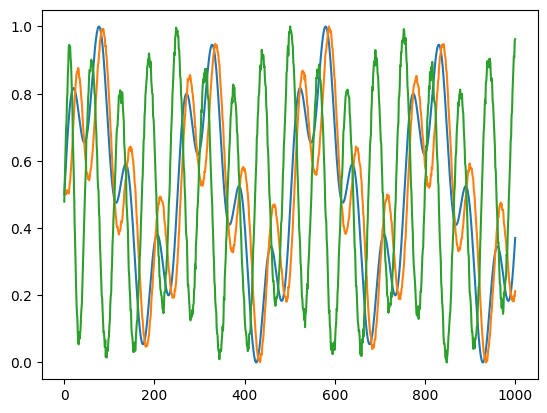

In [10]:
theta_cmd_tensor_norm = (theta_cmd_tensor - theta_cmd_tensor.min(dim=0).values) / (theta_cmd_tensor.max(dim=0).values - theta_cmd_tensor.min(dim=0).values)
theta_out_tensor_norm = (theta_out_tensor - theta_out_tensor.min(dim=0).values) / (theta_out_tensor.max(dim=0).values - theta_out_tensor.min(dim=0).values)
theta_error_tensor_norm = (theta_error_tensor - theta_error_tensor.min(dim=0).values) / (theta_error_tensor.max(dim=0).values - theta_error_tensor.min(dim=0).values)
p_tensor_norm = (p_tensor - p_tensor.min(dim=0).values) / (p_tensor.max(dim=0).values - p_tensor.min(dim=0).values)

plt.plot(theta_cmd_tensor_norm[:,1])
plt.plot(theta_out_tensor_norm[:,1])
plt.plot(theta_error_tensor_norm[:,1]);

In [11]:
Ts = 0.1
Tfinal = 100
length = Tfinal/Ts
time = torch.arange(0, Tfinal + Ts, Ts).view(-1,1)
time_norm =  (time - time.min(dim=0).values) / (time.max(dim=0).values - time.min(dim=0).values)
time_norm_tensor = time_norm.requires_grad_(True)
time_norm_tensor.shape

torch.Size([1001, 1])

## Create X

In [12]:
tensor_list = []
for i in range(params_filtered.shape[0]):
  tensor_2d = (torch.cat((theta_cmd_tensor_norm[:,i].view(-1,1), theta_out_tensor_norm[:,i].view(-1,1),theta_error_tensor_norm[:,i].view(-1,1), p_tensor_norm[:,i].view(-1,1), time_norm_tensor),dim=1))
  tensor_list.append(tensor_2d)
X = torch.stack(tensor_list)
X.shape #this is in the shape of (# of runs, data points, # of features)


torch.Size([735, 1001, 5])

## Create y

In [13]:
# Initialize an empty list to hold rows
tensor_list = []

# Create a 2D tensor in a for loop
for j in range(params_tensor.shape[0]):
    # Create a row tensor for each iteration
    row_tensor = torch.concat((xp_tensor[j,:].view(1,-1),params_tensor_notau[j,:].view(1,-1)),dim=1)
    #row_tensor = torch.cat((xp_tensor[j,:].view(1,-1),params_tensor[j,:].view(1,-1)),dim=1)
    tensor_list.append(row_tensor)

# Stack the list of row tensors to form a 2D tensor
y = torch.stack(tensor_list)
y=torch.squeeze(y)
y.shape


torch.Size([735, 1005])

## Create train/test sets

In [14]:
trainsplit = 70/100

Xtrain = X[:int(trainsplit*X.shape[0]),:,:]
Xtest = X[int(trainsplit*X.shape[0]):,:,:]
ytrain = y[:int(trainsplit*X.shape[0]),:]
ytest = y[int(trainsplit*X.shape[0]):,:]
Xtrain.shape,Xtest.shape,ytrain.shape,ytest.shape

(torch.Size([514, 1001, 5]),
 torch.Size([221, 1001, 5]),
 torch.Size([514, 1005]),
 torch.Size([221, 1005]))

In [15]:
runs=X.shape[0]
p_tensor.T.shape, theta_error_tensor.T.shape

p_tensor_2 = p_tensor.T[:runs,:]
theta_error_tensor_2 = theta_error_tensor.T[:runs,:]

p_tensor_2.shape, theta_error_tensor_2.shape

(torch.Size([735, 1001]), torch.Size([735, 1001]))

In [16]:
pilot_output_train = p_tensor_2[:Xtrain.shape[0],:Xtrain.shape[1]]
theta_error_train = theta_error_tensor_2[:Xtrain.shape[0],:Xtrain.shape[1]]
pilot_output_train.shape ,theta_error_train.shape

(torch.Size([514, 1001]), torch.Size([514, 1001]))

In [17]:
pilot_output_test = p_tensor_2[Xtrain.shape[0]:,:Xtrain.shape[1]]
theta_error_test = theta_error_tensor_2[Xtrain.shape[0]:,:Xtrain.shape[1]]

pilot_output_test.shape,theta_error_test.shape

(torch.Size([221, 1001]), torch.Size([221, 1001]))

In [ ]:
# we are flattening xtrain and xtest so that they are in proper dimensions for linear layers of NN. 
# can keep the original shape of xtrain and xtest if want to try CNN, LSTM, etc. NN structures

Xtrain_flattened = Xtrain.reshape(Xtrain.shape[0], -1)
Xtest_flattened = Xtest.reshape(Xtest.shape[0], -1)

Xtrain_flattened.shape, Xtest_flattened.shape

(torch.Size([514, 5005]), torch.Size([221, 5005]))

# create the NN structure

In [19]:
class DenseModel(nn.Module):
    def __init__(self):
        super(DenseModel, self).__init__()
        # Define the layers
        self.layer1 = nn.Linear(Xtrain_flattened.shape[1], 256)
        self.layer2 = nn.Linear(256, 512)
        self.layer3 = nn.Linear(512, ytrain.shape[1])

    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        x = self.layer3(x)
        return x

# Create an instance of the model
dense_model = DenseModel()

# Create custom dataloader i.e. create the training batches

In [20]:
from torch.utils.data import Dataset, DataLoader

# Create a custom dataset
class CustomDataset(Dataset):
    def __init__(self, X_train, y_train, additional_data1, additional_data2):
        self.X_train = X_train
        self.y_train = y_train
        self.additional_data1 = additional_data1
        self.additional_data2 = additional_data2

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        x = self.X_train[idx]
        y = self.y_train[idx]
        additional1 = self.additional_data1[idx]
        additional2 = self.additional_data2[idx]
        return x, y, additional1, additional2

# Define batch size
batch_size = 32

# Create the custom dataset
custom_dataset = CustomDataset(X_train=Xtrain_flattened, y_train=ytrain, additional_data1=pilot_output_train, additional_data2=theta_error_train)

# Create DataLoader with shuffle=False
train_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

# training parameters

In [21]:
torch.manual_seed(123)

# define the optimiser
optimiser = torch.optim.Adam(dense_model.parameters(), lr=1e-3)

# define the number of epochs
epochs = 20

# collect the loss history
total_loss_history=[]

xpilot_loss_history=[]
params_loss_history=[]
pilot_output_loss_history=[]
ode_loss_history=[]
xpilot_calcualted_loss_history=[]
initial_condition_loss_history=[]

# define the loss criteria
criterion= nn.MSELoss()

# helper function to create delayed data post processing

In [22]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def transport_delay(data, tau, time_step, initial_value):
    """
    Applies a transport delay to a 1D tensor of time series data.

    Parameters:
    - data: 1D PyTorch tensor containing the time series data.
    - tau: The delay in seconds.
    - time_step: The time step between consecutive samples in seconds.
    - initial_value: The value to fill in the delayed portion of the tensor.

    Returns:
    - delayed_data: The tensor with the applied delay.
    """
    if not isinstance(data, torch.Tensor):
        raise ValueError("data should be a PyTorch tensor")

    if data.dim() != 1:
        raise ValueError("data should be a 1D tensor")

    # Calculate the number of samples to delay
    #delay_steps = int(round(tau / time_step))
    delay_steps = (int((tau / time_step)))

    # Ensure delay_steps is non-negative
    delay_steps = max(delay_steps, 0)

    # Create a tensor with the same shape as data, filled with initial_value
    delayed_data = torch.full_like(data, initial_value)

    # Apply the delay by shifting the data tensor
    if delay_steps < len(data):
        delayed_data[delay_steps:] = data[:-delay_steps]
    else:
        # If delay_steps is larger than the data length, return all initial values
        delayed_data = torch.full_like(data, initial_value)

    return delayed_data

# training loop

In [ ]:
torch.manual_seed(123)
for epoch in range(epochs):

    dense_model.train()

    tensor_list = []
    udots = []
    ode_list = []

    xpilot_list=[]

    for batch_X, batch_y, batch_additional1, batch_additional2 in train_loader:

      # Zero the gradients
      optimiser.zero_grad()

      # Forward pass
      xp_est, params_est = dense_model(batch_X)[:,:-4], dense_model(batch_X)[:,-4:]

      # add parameter constraints (params in the order: tld, tlg,kp)
      #lower_bounds = torch.tensor([0.1, 0.25, 0.1])
      #upper_bounds = torch.tensor([3.0, 3.0, 3.0])
      #params_est = torch.clamp(params_est, min=lower_bounds, max=upper_bounds)

      # Compute X_pilot loss
      term1 = xp_est[:,np.linspace(0,xp_est.shape[1]-1,300).astype(int)]
      term2 = batch_y[:,np.linspace(0,xp_est.shape[1]-1,300).astype(int)]
      xpilot_loss = criterion(term1, term2)   # criterion(xp_est, batch_y[:,:-3])
      xpilot_loss_history.append(xpilot_loss.item())

      # Compute parameters loss
      params_loss = criterion(params_est, batch_y[:,-4:])
      params_loss_history.append(params_loss.item())

      # Compute initial conidtion loss
      initial_condition_loss = criterion(xp_est[:,0],torch.zeros(xp_est[:,0].shape[0]))
      initial_condition_loss_history.append(initial_condition_loss.item())
      if epoch > 10: 
        for x in range(batch_X.shape[0]):
          u = xp_est[x,:]
          tld,tlg, tau, kp = params_est[x,0],params_est[x,1],params_est[x,2], params_est[x,3]
          pitcherror_t_tau = transport_delay(batch_additional2[x,:], tau.mean(), 0.1, batch_additional2[x,:][0])

          # Calculate the pilot output loss
          #pilot_output_estimated = ( ((-torch.squeeze(kp)/(torch.squeeze(tlg)*torch.squeeze(tlg)))*(torch.squeeze(tlg)-torch.squeeze(tld))*torch.squeeze(u)) - ((torch.squeeze(kp)*torch.squeeze(tld)/torch.squeeze(tlg))*torch.squeeze(batch_additional2)[x,:]) ).view(1,-1)
          pilot_output_estimated = ( ((-torch.squeeze(kp)/(torch.squeeze(tlg)*torch.squeeze(tlg)))*(torch.squeeze(tlg)-torch.squeeze(tld))*torch.squeeze(u)) - ((torch.squeeze(kp)*torch.squeeze(tld)/torch.squeeze(tlg))*torch.squeeze(pitcherror_t_tau)) ).view(1,-1)
          tensor_list.append(pilot_output_estimated)

          # Calculate the differential equation loss
          udot = torch.autograd.grad(u, time_norm_tensor, torch.ones_like(u), create_graph=True,allow_unused=True)[0]
          udots.append(udot)
          #ode_eq = (torch.squeeze(udot) + ((1/torch.squeeze(tlg))*torch.squeeze(u)) - torch.squeeze(batch_additional2[x,:])).view(1,-1)
          ode_eq = (torch.squeeze(udot) + ((1/torch.squeeze(tlg))*torch.squeeze(u)) - torch.squeeze(pitcherror_t_tau)).view(1,-1)
          ode_list.append(ode_eq)

        # Compile the total pilot output loss
        pilot_output_concat = torch.cat(tensor_list, dim=0)
        pilot_output_loss = criterion(pilot_output_concat,batch_additional1)
        pilot_output_loss_history.append(pilot_output_loss.item())
        tensor_list.clear()

        # Compile the total differential equation loss
        ode_concat = torch.cat(ode_list,dim=0)
        ode_loss = criterion(ode_concat,torch.zeros(ode_concat.shape[0],ode_concat.shape[1]))
        ode_loss_history.append(ode_loss.item())
        ode_list.clear()


      # Compute total loss
      if epoch <=10:
         loss = params_loss + xpilot_loss + initial_condition_loss
      else: 
        loss = params_loss + xpilot_loss + initial_condition_loss + pilot_output_loss + ode_loss
      total_loss_history.append(loss.item())

      # Backward pass
      loss.backward()

      # Update step
      optimiser.step()

    print(f'Epoch {epoch+1}/{epochs}, Total Loss: {loss.item():.4f}')

print("Training complete.")



Epoch 1/20, Total Loss: 0.2370
Epoch 2/20, Total Loss: 0.0823
Epoch 3/20, Total Loss: 0.0616
Epoch 4/20, Total Loss: 0.0629
Epoch 5/20, Total Loss: 0.0659
Epoch 6/20, Total Loss: 0.0659
Epoch 7/20, Total Loss: 0.0667
Epoch 8/20, Total Loss: 0.0697
Epoch 9/20, Total Loss: 0.0738
Epoch 10/20, Total Loss: 0.0759
Epoch 11/20, Total Loss: 0.0767
Epoch 12/20, Total Loss: 0.0811
Epoch 13/20, Total Loss: 0.0843
Epoch 14/20, Total Loss: 0.0848
Epoch 15/20, Total Loss: 0.0878
Epoch 16/20, Total Loss: 0.0874
Epoch 17/20, Total Loss: 0.0860
Epoch 18/20, Total Loss: 0.0849
Epoch 19/20, Total Loss: 0.0852
Epoch 20/20, Total Loss: 0.0847
Training complete.


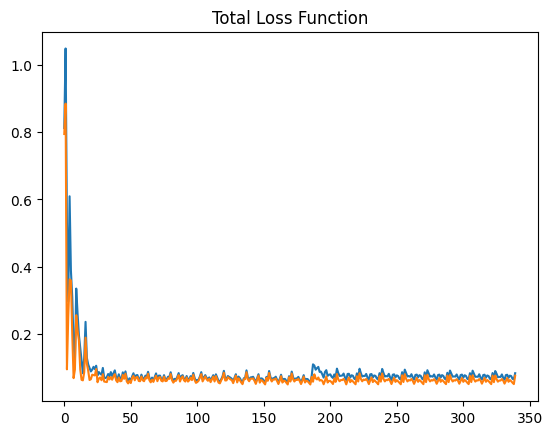

In [ ]:
plt.plot(torch.tensor(total_loss_history),label="total loss")
#plt.plot(torch.tensor(pilot_output_loss_history),label="pilot output loss")
#plt.plot(torch.tensor(xpilot_loss_history),label="xpilot loss")
plt.plot(torch.tensor(params_loss_history),label="parameters loss")
#plt.plot(torch.tensor(ode_loss_history),label="ODE loss")
#plt.plot(torch.tensor(xpilot_calcualted_loss_history),label="calculated xpilot loss")
#plt.plot(torch.tensor(initial_condition_loss_history),label="initial condition loss")
plt.xlabel('Number of batches')
plt.legend()
plt.title('Total Loss Function');

# grab predictions metrics

### parameter metrics

In [30]:
from sklearn.metrics import mean_squared_error
dense_model.eval()

with torch.no_grad():
  dense_model_preds = dense_model(Xtest_flattened)

  true_params = ytest[:,-4:]

  tld_true, tlg_true, tau_true, kp_true = true_params[:,0], true_params[:,1], true_params[:,2], true_params[:,3]

  dense_model_preds_params = dense_model_preds[:,-4:]

  tld_est, tlg_est, tau_est, kp_est = dense_model_preds_params[:,0], dense_model_preds_params[:,1],dense_model_preds_params[:,2], dense_model_preds_params[:,3]

  from sklearn.metrics import mean_absolute_error
  tld_mae = mean_squared_error(tld_true,tld_est)
  tlg_mae = mean_squared_error(tlg_true,tlg_est)
  tau_mae = mean_squared_error(tau_true,tau_est)
  kp_mae = mean_squared_error(kp_true,kp_est)

print(f"T_Lead MSE: {tld_mae}")
print(f"T_Lag MSE: {tlg_mae}")
print(f"tau MSE: {tau_mae}")
print(f"K_P MSE: {kp_mae}")

T_Lead MSE: 0.08239284157752991
T_Lag MSE: 0.08644309639930725
tau MSE: 0.015257242135703564
K_P MSE: 0.06738393753767014


In [52]:
tld_mae = mean_absolute_error(tld_true,tld_est)
tlg_mae = mean_absolute_error(tlg_true,tlg_est)
tau_mae = mean_absolute_error(tau_true,tau_est)
kp_mae = mean_absolute_error(kp_true,kp_est)
tld_mae, tlg_mae, tau_mae, kp_mae

(0.23668812, 0.25013798, 0.10636362, 0.22290729)

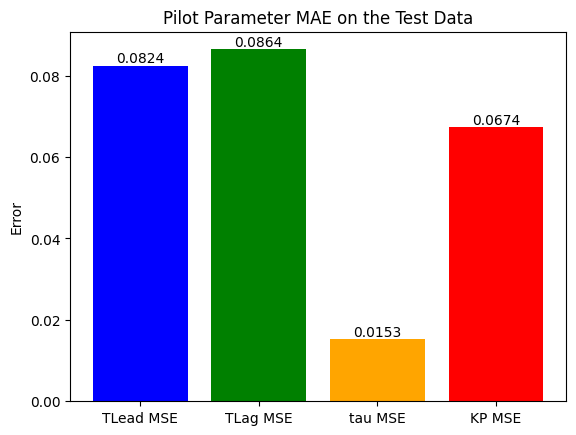

In [31]:
values = [tld_mae, tlg_mae, tau_mae, kp_mae]

# Corresponding labels for each value
labels = ["TLead MSE", "TLag MSE", "tau MSE", "KP MSE"]

# Specify colors for each bar
colors = ['blue', 'green', 'orange','red']

# Create a bar plot
plt.bar(labels, values,color=colors)

# Add labels to each bar
for label, value in zip(labels, values):
    plt.text(label, value , '{:.4f}'.format(value), ha='center', va='bottom')

# Add labels and title
plt.title('Pilot Parameter MAE on the Test Data')
plt.ylabel('Error')
#plt.title('Bar Plot of Four Values')

# Display the plot
plt.show()

### x(t) metrics

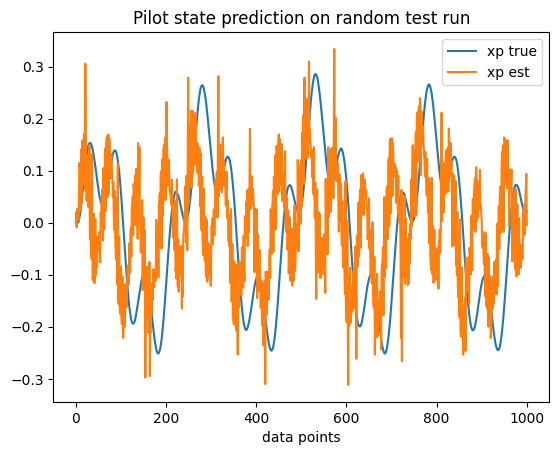

In [ ]:
xp_true = ytest[:,:-4]
xp_est = dense_model_preds[:,:-4]

#
#-------------------------
i=7
plt.plot(xp_true[i,:],label="xp true")
plt.plot(xp_est[i,:],label="xp est")
plt.xlabel('data points')
plt.legend()
plt.title('Pilot state prediction on random test run')
plt.show()

In [34]:
mean_squared_error(xp_true, xp_est)

0.013459144

### p(t) metrics

'\nplt.plot(pilot_output_estimated,label="p(t) est")\nplt.xlabel(\'data points\')\nplt.legend()\nplt.title(\'Pilot output prediction on random test run\')\nplt.show()\n'

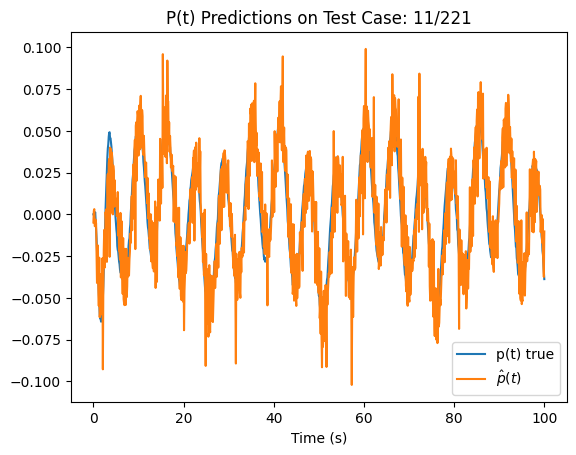

In [ ]:
i=11
plt.plot(time, pilot_output_test[i,:],label="p(t) true")
tld_est_int = tld_est[i]
tlg_est_int = tlg_est[i]
tau_est_int = tau_est[i]
tau_est_avg = tau_est_int.mean()
kp_est_int = kp_est[i]

pitcherror_t_tau = transport_delay(theta_error_test[i,:], tau_est_avg, 0.1, theta_error_test[i,:][0])

pilot_output_predicted = (-kp_est_int/(tlg_est_int*tlg_est_int)) * (tlg_est_int-tld_est_int) * xp_est[i,:] - (kp_est_int*tld_est_int/tlg_est_int)*pitcherror_t_tau

plt.plot(time,pilot_output_predicted,label="$\hat{p}(t)$")
plt.xlabel('Time (s)')
plt.legend()
plt.title(f'P(t) Predictions on Test Case: {i}/{len(Xtest_flattened)}');
plt.show();

In [42]:
# Initialize an empty list to store the tensors
pilot_output_predicted_list = []

for k in range(len(Xtest_flattened)):
  tld_est_int = tld_est[k]
  tlg_est_int = tlg_est[k]
  tau_est_int = tau_est[k]
  tau_est_avg = tau_est_int.mean()
  kp_est_int = kp_est[k]

  pitcherror_t_tau = transport_delay(theta_error_test[k,:], tau_est_avg, 0.1, theta_error_test[k,:][0])
  pilot_output_predicted = (-kp_est_int/(tlg_est_int*tlg_est_int)) * (tlg_est_int-tld_est_int) * xp_est[k,:] - (kp_est_int*tld_est_int/tlg_est_int)*pitcherror_t_tau

  # Append to the list
  pilot_output_predicted_list.append(pilot_output_predicted)


# Convert the list to a 2D tensor (NumPy array)
pilot_output_predicted_tensor = np.stack(pilot_output_predicted_list)

pilot_output_predicted_tensor.shape, pilot_output_test.shape

((221, 1001), torch.Size([221, 1001]))

In [44]:
mean_squared_error(pilot_output_test,pilot_output_predicted_tensor)

0.0012033278